# **LeMaterial/LeMat-Synth Dataset Analysis**

This notebook is a data analysis of LeMaterial/LeMat-Synth dataset

## **Available Dataset Splits**
- **arxiv**: ArXiv research papers
- **chemrxiv**: ChemRxiv chemistry papers  
- **omg24**: OMG24 conference papers
- **sample_for_evaluation**: Evaluation samples

## **Load libraries**

In [ ]:
# Install required packages
!pip install pandas pyarrow matplotlib seaborn plotly python-dotenv requests -q
# install dotenv package
!pip install python-dotenv -q
# install tqdm package
!pip install tqdm -q
# installl wordcloud package
!pip install wordcloud -q

print("✅ Packages installed successfully!")

✅ Packages installed successfully!


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from collections import defaultdict
import re
import ast

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

import plotly.express as px

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [ ]:
# 1. Get (Colab secret) token or manually paste (for debug)
try:
    from google.colab import userdata
    HF_TOKEN = userdata.get('HF_TOKEN')
except Exception as e:
    HF_TOKEN = ""  # Optionally paste your token here
print("HF_TOKEN is present:", bool(HF_TOKEN))

import os
os.environ['HF_TOKEN'] = HF_TOKEN

HF_TOKEN is present: True


In [ ]:
# 2. Clean existing files (avoid 0-byte problems)
for fname in ["arxiv.parquet", "chemrxiv.parquet", "omg24.parquet", "sample_for_evaluation.parquet"]:
    if os.path.exists(fname):
        os.remove(fname)

# 3. Download only the smaller datasets with curl and token
urls = {
    # Commenting out larger datasets to avoid memory issues
    # "arxiv.parquet": "https://huggingface.co/datasets/LeMaterial/LeMat-Synth/resolve/main/data/arxiv/arxiv.parquet",
    # "chemrxiv.parquet": "https://huggingface.co/datasets/LeMaterial/LeMat-Synth/resolve/main/data/chemrxiv/chemrxiv.parquet",
    # "omg24.parquet": "https://huggingface.co/datasets/LeMaterial/LeMat-Synth/resolve/main/data/omg24/omg24.parquet",
    "sample_for_evaluation.parquet": "https://huggingface.co/datasets/LeMaterial/LeMat-Synth/resolve/main/data/sample_for_evaluation-00000-of-00001.parquet"
}
for filename, url in urls.items():
    ret = os.system(f'curl -L -H "Authorization: Bearer $HF_TOKEN" "{url}" -o {filename}')
    print(f"Download {filename} exit code: {ret}")

# 4. Show file sizes and file types
!ls -lh *.parquet
!file *.parquet

Download sample_for_evaluation.parquet exit code: 0
-rw-r--r-- 1 root root 159M Aug  4 15:01 sample_for_evaluation.parquet
sample_for_evaluation.parquet: Apache Parquet


## **Data set exploration**

### **Understand the data**

Create new column 'source'

Examine the columns, data types, and basic statistics.

In [ ]:
# Load the data
data = pd.read_parquet("sample_for_evaluation.parquet")

In [ ]:
# Extract the domain name from the URL
data["source"] = data["paper_url"].astype(str).str.extract(r'//([^/]+)')

# Cleaning: remove extensions
data["source"] = (
    data["source"]
    .str.replace(r'^www\.', '', regex=True)
    .str.replace(r'^onlinelibrary\.', '', regex=True)
    .str.replace(r'^link\.', '', regex=True)
    .str.replace(r'\.org$|\.com$|\.net$|\.edu$|\.info$', '', regex=True)
)

print(data[["paper_url", "source"]].head())

                           paper_url source
0  http://arxiv.org/pdf/2307.06888v2  arxiv
1  http://arxiv.org/pdf/2307.06888v2  arxiv
2  http://arxiv.org/pdf/2307.06888v2  arxiv
3  http://arxiv.org/pdf/2307.06888v2  arxiv
4  http://arxiv.org/pdf/2307.06888v2  arxiv


In [ ]:
print(data.shape)

(589, 17)


In [ ]:
# View first 5 rows
data.head()

,synthesized_material,material_category,synthesis_method,images,plot_data,structured_synthesis,evaluation,synthesis_extraction_performance_llm,figure_extraction_performance_llm,synthesis_extraction_performance_human,figure_extraction_performance_human,paper_title,paper_published_date,paper_abstract,paper_doi,paper_url,source
0,Ta/NiFe/Ru/NiFe/Ta,nanomaterials,PVD,[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...,None,"{'target_compound': 'Ta/NiFe/Ru/NiFe/Ta', 'tar...",{'reasoning': 'The extracted ontology captures...,NaN,NaN,NaN,NaN,Magnon-magnon coupling in synthetic ferrimagnets,2023,Magnetic multilayers with interlayer exchang...,None,http://arxiv.org/pdf/2307.06888v2,arxiv
1,Ta/CoFeB/Ru/NiFe/Ta,nanomaterials,PVD,[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...,None,"{'target_compound': 'Ta/CoFeB/Ru/NiFe/Ta', 'ta...",{'reasoning': 'The extracted ontology captures...,NaN,NaN,NaN,NaN,Magnon-magnon coupling in synthetic ferrimagnets,2023,Magnetic multilayers with interlayer exchang...,None,http://arxiv.org/pdf/2307.06888v2,arxiv
2,NiFe(5)/Ru(0.4)/NiFe(3),nanomaterials,PVD,[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...,None,"{'target_compound': 'NiFe(5)/Ru(0.4)/NiFe(3)',...",{'reasoning': 'The extracted ontology captures...,NaN,NaN,NaN,NaN,Magnon-magnon coupling in synthetic ferrimagnets,2023,Magnetic multilayers with interlayer exchang...,None,http://arxiv.org/pdf/2307.06888v2,arxiv
3,NiFe(3)/Ru(0.4)/NiFe(5),nanomaterials,PVD,[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...,None,"{'target_compound': 'NiFe(3)/Ru(0.4)/NiFe(5)',...",{'reasoning': 'The extracted ontology captures...,NaN,NaN,NaN,NaN,Magnon-magnon coupling in synthetic ferrimagnets,2023,Magnetic multilayers with interlayer exchang...,None,http://arxiv.org/pdf/2307.06888v2,arxiv
4,CoFeB(3)/Ru(0.45)/NiFe(3),nanomaterials,PVD,[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...,None,{'target_compound': 'CoFeB(3)/Ru(0.45)/NiFe(3)...,{'reasoning': 'The extraction captures the cor...,NaN,NaN,NaN,NaN,Magnon-magnon coupling in synthetic ferrimagnets,2023,Magnetic multilayers with interlayer exchang...,None,http://arxiv.org/pdf/2307.06888v2,arxiv


In [ ]:
# View last 5 rows Hint: Use tail() method
data.tail()

,synthesized_material,material_category,synthesis_method,images,plot_data,structured_synthesis,evaluation,synthesis_extraction_performance_llm,figure_extraction_performance_llm,synthesis_extraction_performance_human,figure_extraction_performance_human,paper_title,paper_published_date,paper_abstract,paper_doi,paper_url,source
584,[HRhMOP(diz)12],framework & porous materials,wet chemical synthesis,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None,"{'target_compound': '[HRhMOP(diz)12]', 'target...",None,NaN,NaN,NaN,NaN,A Coordinative Solubilizer Method to Fabricate...,2018-12-13T17:32:42.000Z,<p>Porous molecular cages have a characteristi...,10.26434/chemrxiv.7460618.v1,https://chemrxiv.org/engage/api-gateway/chemrx...,chemrxiv
585,coordination polymer particles (CPP),nanomaterials,wet chemical synthesis,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None,{'target_compound': 'coordination polymer part...,{'reasoning': 'The extraction accurately and c...,NaN,NaN,NaN,NaN,A Coordinative Solubilizer Method to Fabricate...,2018-12-13T17:32:42.000Z,<p>Porous molecular cages have a characteristi...,10.26434/chemrxiv.7460618.v1,https://chemrxiv.org/engage/api-gateway/chemrx...,chemrxiv
586,[HRhMOP(bix)9.6(diz)2.4],hybrid & organic-inorganic,wet chemical synthesis,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None,{'target_compound': '[HRhMOP(bix)9.6(diz)2.4]'...,{'reasoning': 'The extracted ontology provides...,NaN,NaN,NaN,NaN,A Coordinative Solubilizer Method to Fabricate...,2018-12-13T17:32:42.000Z,<p>Porous molecular cages have a characteristi...,10.26434/chemrxiv.7460618.v1,https://chemrxiv.org/engage/api-gateway/chemrx...,chemrxiv
587,supramolecular colloidal gel (SCG),polymers & soft matter,self-assembly,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None,{'target_compound': 'supramolecular colloidal ...,{'reasoning': 'The extracted ontology provides...,NaN,NaN,NaN,NaN,A Coordinative Solubilizer Method to Fabricate...,2018-12-13T17:32:42.000Z,<p>Porous molecular cages have a characteristi...,10.26434/chemrxiv.7460618.v1,https://chemrxiv.org/engage/api-gateway/chemrx...,chemrxiv
588,supramolecular aerogel (SAG),framework & porous materials,other,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None,{'target_compound': 'supramolecular aerogel (S...,{'reasoning': 'The extraction accurately captu...,NaN,NaN,NaN,NaN,A Coordinative Solubilizer Method to Fabricate...,2018-12-13T17:32:42.000Z,<p>Porous molecular cages have a characteristi...,10.26434/chemrxiv.7460618.v1,https://chemrxiv.org/engage/api-gateway/chemrx...,chemrxiv


In [ ]:
# View all the dataframe
display(data)

,synthesized_material,material_category,synthesis_method,images,plot_data,structured_synthesis,evaluation,synthesis_extraction_performance_llm,figure_extraction_performance_llm,synthesis_extraction_performance_human,figure_extraction_performance_human,paper_title,paper_published_date,paper_abstract,paper_doi,paper_url,source
0,Ta/NiFe/Ru/NiFe/Ta,nanomaterials,PVD,[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...,None,"{'target_compound': 'Ta/NiFe/Ru/NiFe/Ta', 'tar...",{'reasoning': 'The extracted ontology captures...,NaN,NaN,NaN,NaN,Magnon-magnon coupling in synthetic ferrimagnets,2023,Magnetic multilayers with interlayer exchang...,None,http://arxiv.org/pdf/2307.06888v2,arxiv
1,Ta/CoFeB/Ru/NiFe/Ta,nanomaterials,PVD,[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...,None,"{'target_compound': 'Ta/CoFeB/Ru/NiFe/Ta', 'ta...",{'reasoning': 'The extracted ontology captures...,NaN,NaN,NaN,NaN,Magnon-magnon coupling in synthetic ferrimagnets,2023,Magnetic multilayers with interlayer exchang...,None,http://arxiv.org/pdf/2307.06888v2,arxiv
2,NiFe(5)/Ru(0.4)/NiFe(3),nanomaterials,PVD,[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...,None,"{'target_compound': 'NiFe(5)/Ru(0.4)/NiFe(3)',...",{'reasoning': 'The extracted ontology captures...,NaN,NaN,NaN,NaN,Magnon-magnon coupling in synthetic ferrimagnets,2023,Magnetic multilayers with interlayer exchang...,None,http://arxiv.org/pdf/2307.06888v2,arxiv
3,NiFe(3)/Ru(0.4)/NiFe(5),nanomaterials,PVD,[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...,None,"{'target_compound': 'NiFe(3)/Ru(0.4)/NiFe(5)',...",{'reasoning': 'The extracted ontology captures...,NaN,NaN,NaN,NaN,Magnon-magnon coupling in synthetic ferrimagnets,2023,Magnetic multilayers with interlayer exchang...,None,http://arxiv.org/pdf/2307.06888v2,arxiv
4,CoFeB(3)/Ru(0.45)/NiFe(3),nanomaterials,PVD,[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...,None,{'target_compound': 'CoFeB(3)/Ru(0.45)/NiFe(3)...,{'reasoning': 'The extraction captures the cor...,NaN,NaN,NaN,NaN,Magnon-magnon coupling in synthetic ferrimagnets,2023,Magnetic multilayers with interlayer exchang...,None,http://arxiv.org/pdf/2307.06888v2,arxiv
5,CoFeB(3)/Ru(0.5)/NiFe(3),nanomaterials,PVD,[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...,None,{'target_compound': 'CoFeB(3)/Ru(0.5)/NiFe(3)'...,{'reasoning': 'The extracted ontology captures...,NaN,NaN,NaN,NaN,Magnon-magnon coupling in synthetic ferrimagnets,2023,Magnetic multilayers with interlayer exchang...,None,http://arxiv.org/pdf/2307.06888v2,arxiv
6,CoFeB(3)/Ru(0.55)/NiFe(3),nanomaterials,PVD,[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...,None,{'target_compound': 'CoFeB(3)/Ru(0.55)/NiFe(3)...,{'reasoning': 'The extraction captures the cor...,NaN,NaN,NaN,NaN,Magnon-magnon coupling in synthetic ferrimagnets,2023,Magnetic multilayers with interlayer exchang...,None,http://arxiv.org/pdf/2307.06888v2,arxiv
7,NiFe(5)/Ru(0.4)/NiFe(5),nanomaterials,PVD,[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...,None,"{'target_compound': 'NiFe(5)/Ru(0.4)/NiFe(5)',...",{'reasoning': 'The extracted ontology captures...,NaN,NaN,NaN,NaN,Magnon-magnon coupling in synthetic ferrimagnets,2023,Magnetic multilayers with interlayer exchang...,None,http://arxiv.org/pdf/2307.06888v2,arxiv
8,5-AGNR,two-dimensional materials,CVD,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None,"{'target_compound': '5-AGNR', 'target_compound...",{'reasoning': 'The extracted ontology captures...,NaN,NaN,NaN,NaN,Structure-dependent electrical properties of g...,2019,Graphene nanoribbons (GNRs) are a novel and ...,10.1016/j.carbon.2019.01.071,http://arxiv.org/pdf/1902.03049v1,arxiv
9,9-AGNR,two-dimensional materials,CVD,[{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...,None,"{'target_compound': '9-AGNR', 'target_compound...",{'reasoning': 'The extracted ontology captures...,NaN,NaN,NaN,NaN,Structure-dependent electrical properties of g...,2019,Graphene nanoribbons (GNRs) are a novel and ...,10.1016/j.carbon.2019.01.071,http://arxiv.org/pdf/1902.03049v1,arxiv


In [ ]:
# Check the datatypes of each column.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   synthesized_material                    589 non-null    object 
 1   material_category                       589 non-null    object 
 2   synthesis_method                        589 non-null    object 
 3   images                                  575 non-null    object 
 4   plot_data                               0 non-null      object 
 5   structured_synthesis                    589 non-null    object 
 6   evaluation                              522 non-null    object 
 7   synthesis_extraction_performance_llm    0 non-null      float64
 8   figure_extraction_performance_llm       0 non-null      float64
 9   synthesis_extraction_performance_human  0 non-null      float64
 10  figure_extraction_performance_human     0 non-null      float6

In [ ]:
# Numerical statistics
data.describe()

,synthesis_extraction_performance_llm,figure_extraction_performance_llm,synthesis_extraction_performance_human,figure_extraction_performance_human
count,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN


### **Handle missing values**

Identify and address any missing values in the DataFrame.

In [ ]:
missing_percentages = data.isnull().sum()
print("Percentage of missing values per column:")
print(missing_percentages)
if 'images' in data.columns:
   data = data.drop('images', axis=1)
   print("\n'images' column dropped.")

# Fill remaining missing values with "N/A"
data = data.fillna("N/A")
print("\nRemaining missing values filled with 'N/A'.")

# Verify that there are no more missing values
print("\nMissing values after handling:")
print(data.isnull().sum().sum())

Percentage of missing values per column:
synthesized_material                        0
material_category                           0
synthesis_method                            0
images                                     14
plot_data                                 589
structured_synthesis                        0
evaluation                                 67
synthesis_extraction_performance_llm      589
figure_extraction_performance_llm         589
synthesis_extraction_performance_human    589
figure_extraction_performance_human       589
paper_title                                 0
paper_published_date                        0
paper_abstract                              0
paper_doi                                 119
paper_url                                   0
source                                      0
dtype: int64

'images' column dropped.

Remaining missing values filled with 'N/A'.

Missing values after handling:
0


## **Data Visualisation**

 Create visualizations to understand the distribution and relationships within the data.

### **Summary statistics of all categorical variables**

In [ ]:
# Explore basic summary statistics of categorical variables.
data.describe(include=['object'])

,synthesized_material,material_category,synthesis_method,plot_data,structured_synthesis,evaluation,synthesis_extraction_performance_llm,figure_extraction_performance_llm,synthesis_extraction_performance_human,figure_extraction_performance_human,paper_title,paper_published_date,paper_abstract,paper_doi,paper_url,source
count,589,589,589,589,589,589,589,589,589,589,589,589,589,589,589,589
unique,568,25,49,1,589,523,1,1,1,1,223,117,211,168,223,8
top,No materials synthesized,functional materials,wet chemical synthesis,N/A,{'target_compound': 'supramolecular aerogel (S...,N/A,N/A,N/A,N/A,N/A,"Insight into Stable, Concentrated Radicals: fr...",2023,N/A,N/A,https://chemrxiv.org/engage/api-gateway/chemrx...,chemrxiv
freq,20,95,199,589,1,67,589,589,589,589,21,37,36,119,21,334


### **Word cloud of actions**

Total actions extracted: 1849


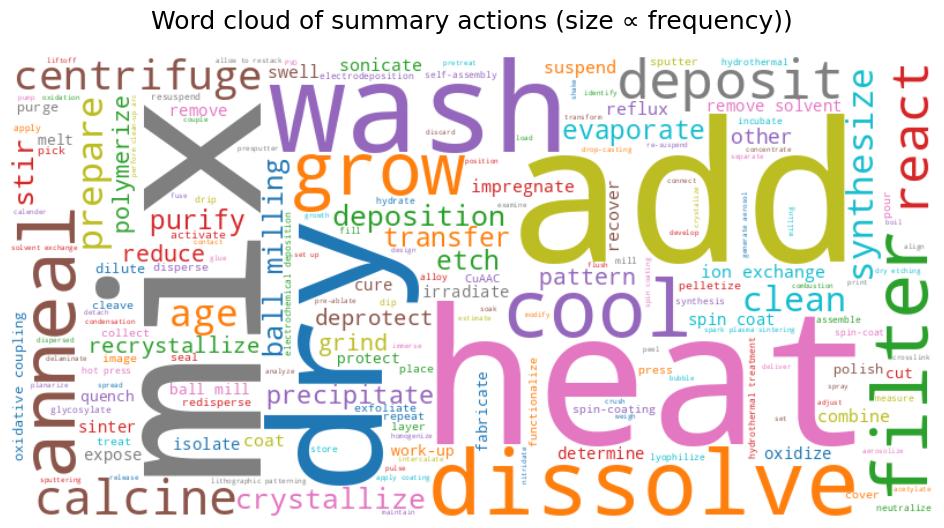

In [ ]:
# Extracting the ‘actions’ from each step (simplified loop)
actions = []
for idx, raw in enumerate(data['structured_synthesis']):
    try:
        record = json.loads(raw) if isinstance(raw, str) else raw
        for step in record.get('steps', []):
            action = step.get('action')
            if isinstance(action, str) and action:
                actions.append(action)
    except (json.JSONDecodeError, TypeError):
        continue

print(f"Total actions extracted: {len(actions)}")

# Frequency calculation
freq = Counter(actions)

# Preparation and generation of the word cloud
if freq:
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='tab10',
        relative_scaling=0.5,
        normalize_plurals=False
    )
    wc.generate_from_frequencies(freq)

# Display
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(
        "Word cloud of summary actions (size ∝ frequency))",
        fontsize=18,
        pad=20
    )
    plt.show()
else:
    print("No actions found to generate a word cloud.")

### **Distribution of publications by date**

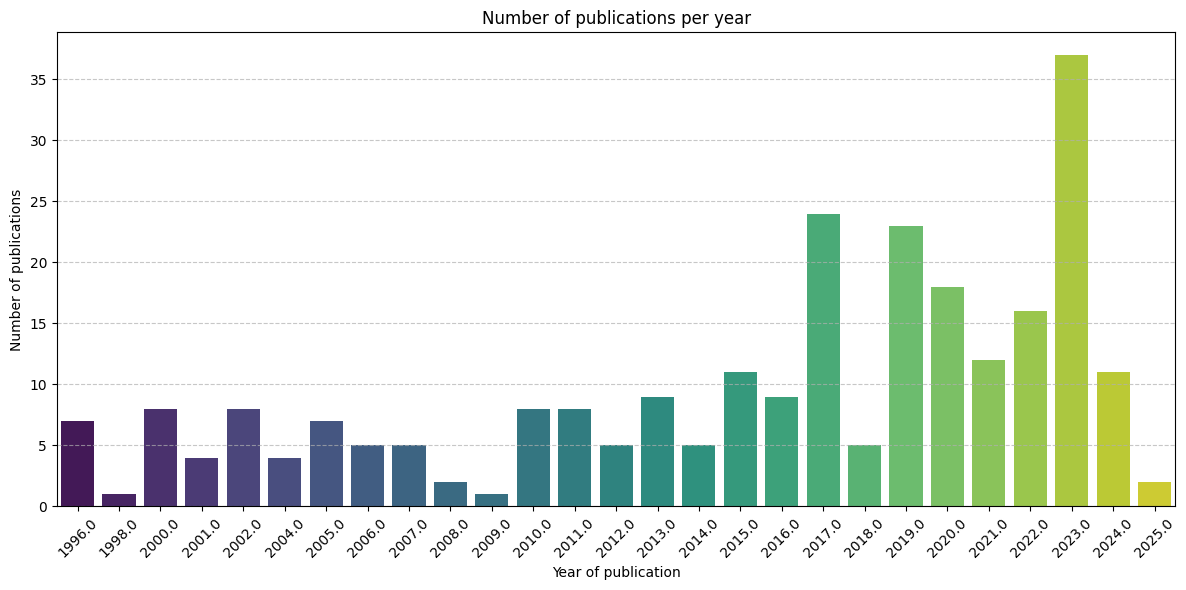

In [ ]:
data['paper_published_date'] = pd.to_datetime(data['paper_published_date'], errors='coerce')

plt.figure(figsize=(12, 6))
data['published_year'] = data['paper_published_date'].dt.year
sns.countplot(data=data, x='published_year', palette='viridis')
plt.title('Number of publications per year')
plt.xlabel('Year of publication')
plt.ylabel('Number of publications')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Observations**

The dataset spans publication dates from 1996 to 2025, with a median publication year of 2019, indicating a concentration of more recent papers. The year 2023 has the highest number of publications in the dataset.

### **Distribution of source**

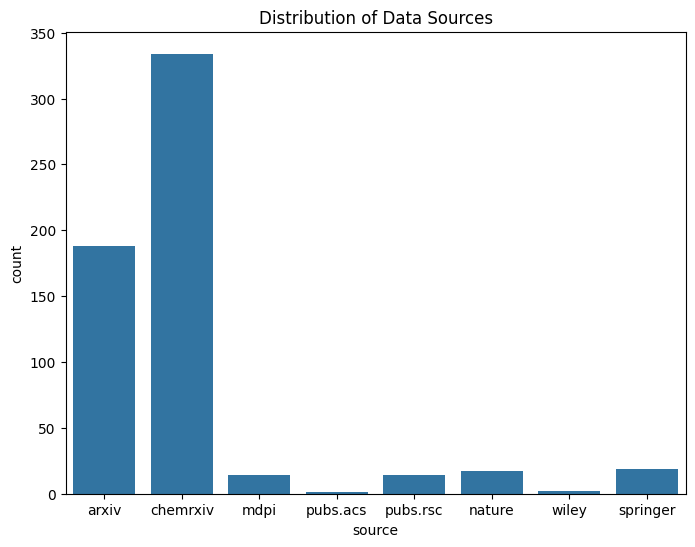

In [ ]:
# Create a countplot of the 'source' column
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='source')
plt.title("Distribution of Data Sources")
plt.show()

In [ ]:
data['source'].value_counts()

,count
source,
chemrxiv,334
arxiv,188
springer,19
nature,17
pubs.rsc,14
mdpi,14
wiley,2
pubs.acs,1


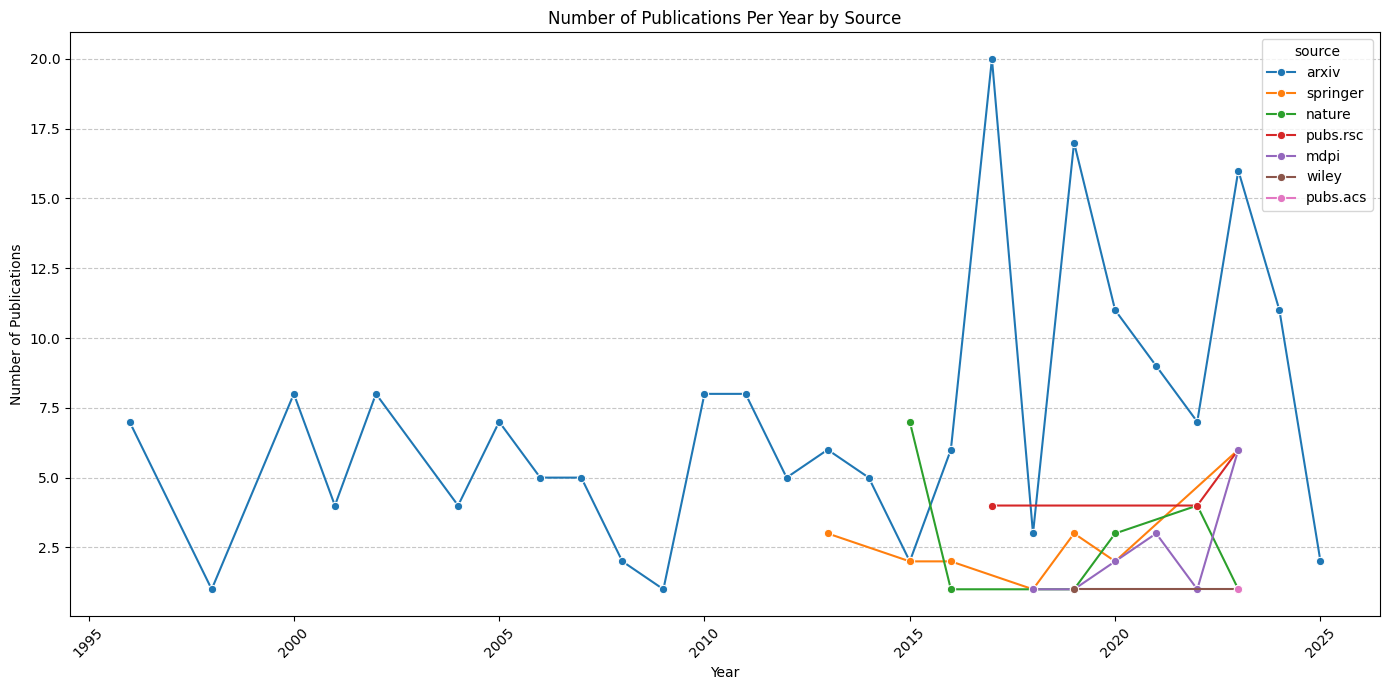

In [ ]:
# Filter out rows with missing year (due to coercion errors)
yearly_data = data.dropna(subset=['published_year'])

# Group by year and source and count the publications
yearly_counts = yearly_data.groupby(['published_year', 'source']).size().reset_index(name='count')

# Plotting the number of publications per year by source
plt.figure(figsize=(14, 7))
sns.lineplot(data=yearly_counts, x='published_year', y='count', hue='source', marker='o')
plt.title('Number of Publications Per Year by Source')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### **Top of synthetized materials**

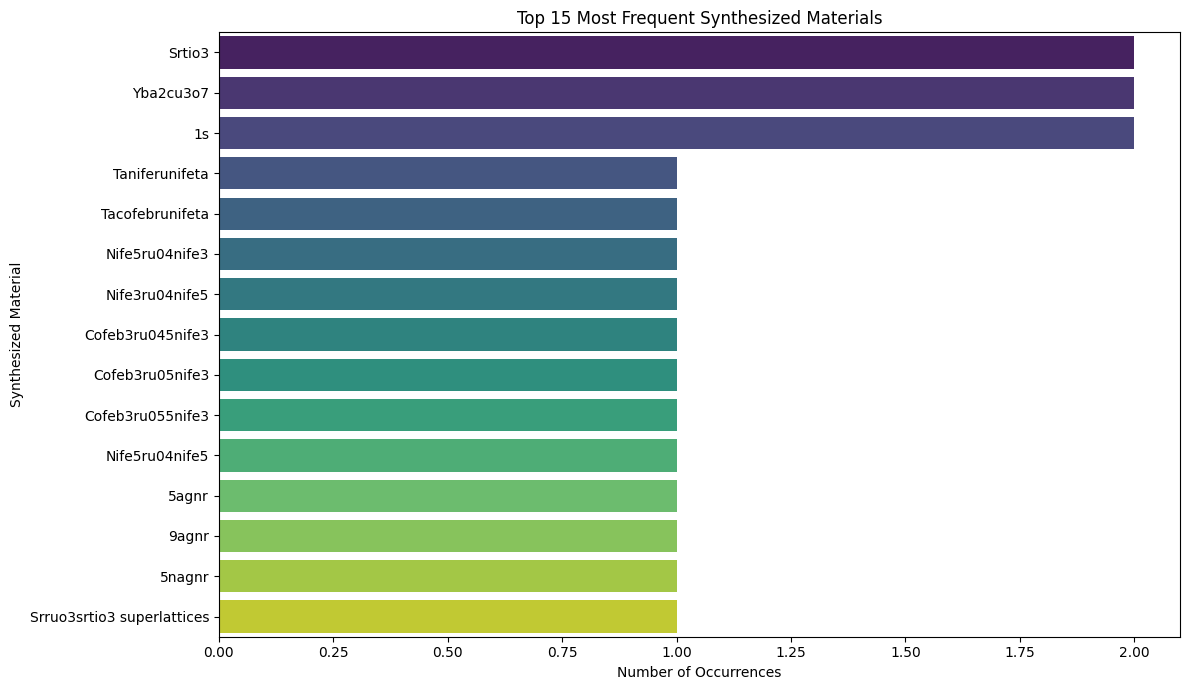

In [ ]:
# Simple cleaning function
def clean_material(material):
    if isinstance(material, str):
        material = re.sub(r'[^a-zA-Z0-9\s]', '', material).strip().capitalize()
        # Exclude generic terms, missing values, and "No materials synthesized"
        if material.lower() not in ['na', 'n/a', 'other', 'others', 'no materials synthesized']:
            return material
    return None

# Apply cleaning to 'synthesized_material'
data['cleaned_synthesized_material'] = data['synthesized_material'].apply(clean_material)

# Count the occurrences of valid synthesized materials
material_counts = Counter(data['cleaned_synthesized_material'].dropna())

# Convert to DataFrame for visualisation
df_materials = pd.DataFrame(material_counts.most_common(15), columns=['Synthesized Material', 'Count'])

# Displaying with Seaborn
plt.figure(figsize=(12, 7))
sns.barplot(data=df_materials, x='Count', y='Synthesized Material', palette='viridis')
plt.title('Top 15 Most Frequent Synthesized Materials')
plt.xlabel('Number of Occurrences')
plt.ylabel('Synthesized Material')
plt.tight_layout()
plt.show()

### **Frenquency of material categories**

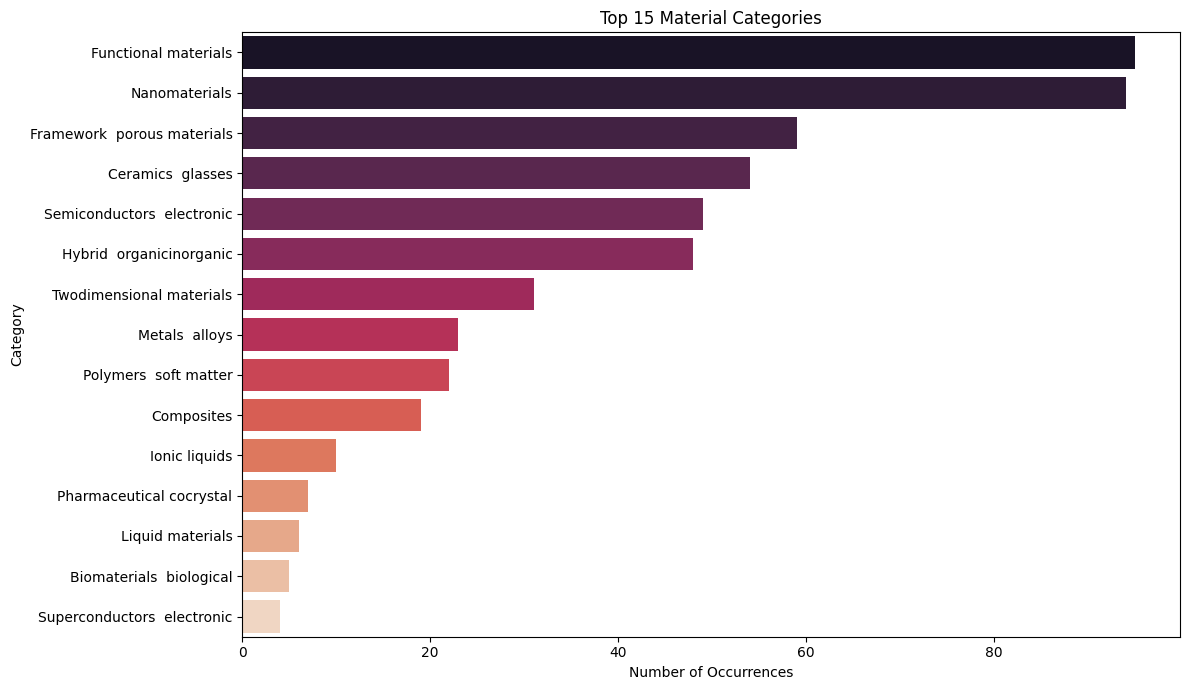

In [ ]:
# Simplified function for cleaning a single category
def clean_category(cat):
    if isinstance(cat, str):
        cat = re.sub(r'[^a-zA-Z0-9\s]', '', cat).strip()
        cat = cat.capitalize()
        if cat.lower() not in ['material', 'science', 'others', 'n/a', 'other', 'na']:  # Filters out irrelevant cases
            return cat
    return None

# Apply cleaning
data['cleaned_category'] = data['material_category'].apply(clean_category)

# Count the occurrences of valid categories
category_counts = Counter(data['cleaned_category'].dropna())

# Convert to DataFrame for visualisation
df_categories = pd.DataFrame(category_counts.most_common(15), columns=['Category', 'Count'])

# Displaying with Seaborn
plt.figure(figsize=(12, 7))
sns.barplot(data=df_categories, x='Count', y='Category', palette='rocket')
plt.title('Top 15 Material Categories')
plt.xlabel('Number of Occurrences')
plt.ylabel('Category')
plt.tight_layout()
plt.show()


In [ ]:
# Combine categories from all sources with category data
all_categories = []
# Using the main 'data' DataFrame and iterating through rows
if 'data' in globals():
    for index, row in data.iterrows():
        # Use the cleaned categories if available, otherwise clean them here
        categories = row.get('cleaned_categories')
        if categories is None or not isinstance(categories, list):
            # If not available or not a list, clean from the original 'categories' column
            # Re-using the cleaning logic from elsewhere for consistency
            def clean_single_category_entry(categories_list):
                cleaned = []
                if isinstance(categories_list, str):
                    try:
                        categories_list = ast.literal_eval(categories_list)
                    except (ValueError, SyntaxError):
                        categories_list = [categories_list]

                if isinstance(categories_list, list):
                    for category in categories_list:
                        if isinstance(category, str):
                            for part in category.split(','):
                                for sub_part in part.split(';'):
                                     cleaned_category = sub_part.strip()
                                     if cleaned_category:
                                         cleaned.append(cleaned_category)
                return cleaned
            categories = clean_single_category_entry(row['material_category'])


        # Filter out 'N/A', 'Other', 'Others', 'NA' (case-insensitive)
        filtered_categories = [cat for cat in categories if isinstance(cat, str) and cat.lower() not in ['n/a', 'other', 'others', 'na']]
        all_categories.extend(filtered_categories)

if all_categories:
    # Count the frequency of each category
    category_counts = Counter(all_categories)
    category_df = pd.DataFrame(category_counts.items(), columns=['Category', 'Count'])

    # Create a treemap
    fig = px.treemap(category_df, path=['Category'], values='Count',
                     title='Interactive Treemap of Material Categories')
    fig.show()
else:
    print("No category data available to create a treemap after filtering.")

### **Top of synthesis methods**

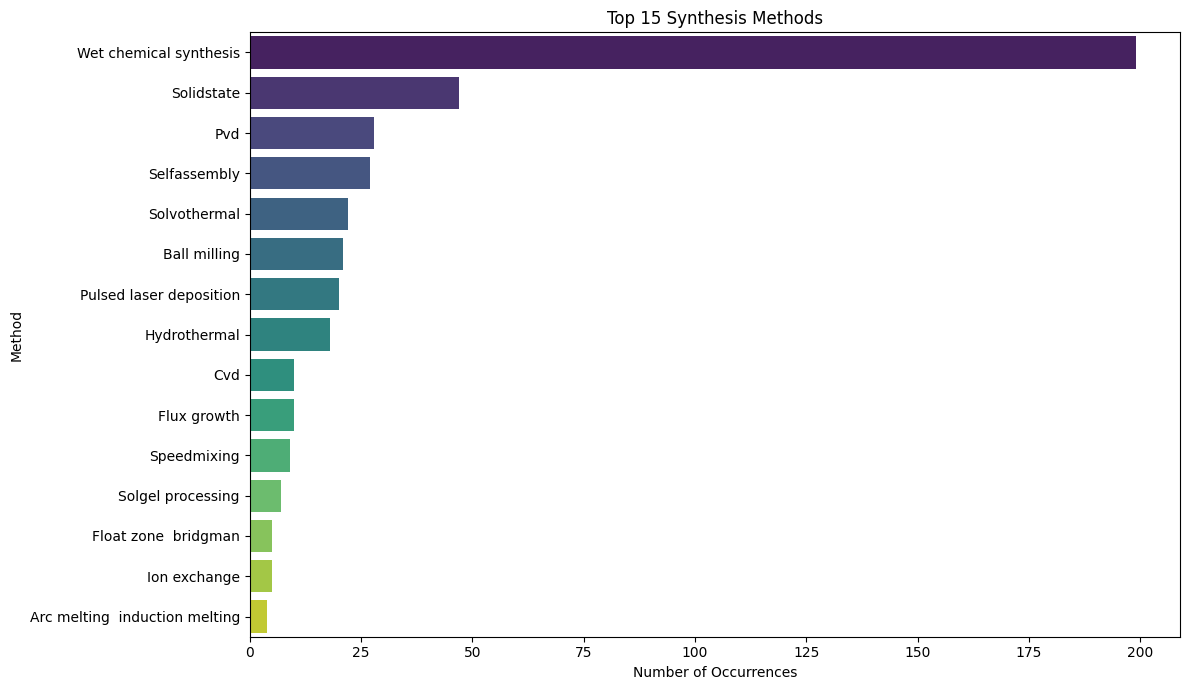

In [ ]:
# Apply cleaning to 'synthesis_method'
data['cleaned_synthesis_method'] = data['synthesis_method'].apply(clean_category)

# Count the occurrences of valid synthesis methods
method_counts = Counter(data['cleaned_synthesis_method'].dropna())

# Convert to DataFrame for visualisation
df_methods = pd.DataFrame(method_counts.most_common(15), columns=['Method', 'Count'])

# Displaying with Seaborn
plt.figure(figsize=(12, 7))
sns.barplot(data=df_methods, x='Count', y='Method', palette='viridis')
plt.title('Top 15 Synthesis Methods')
plt.xlabel('Number of Occurrences')
plt.ylabel('Method')
plt.tight_layout()
plt.show()

## **Advanced data exploration**

Perform a deeper dive into the dataset by exploring relationships between columns.

### **Correlation between synthesized materials and material categories**

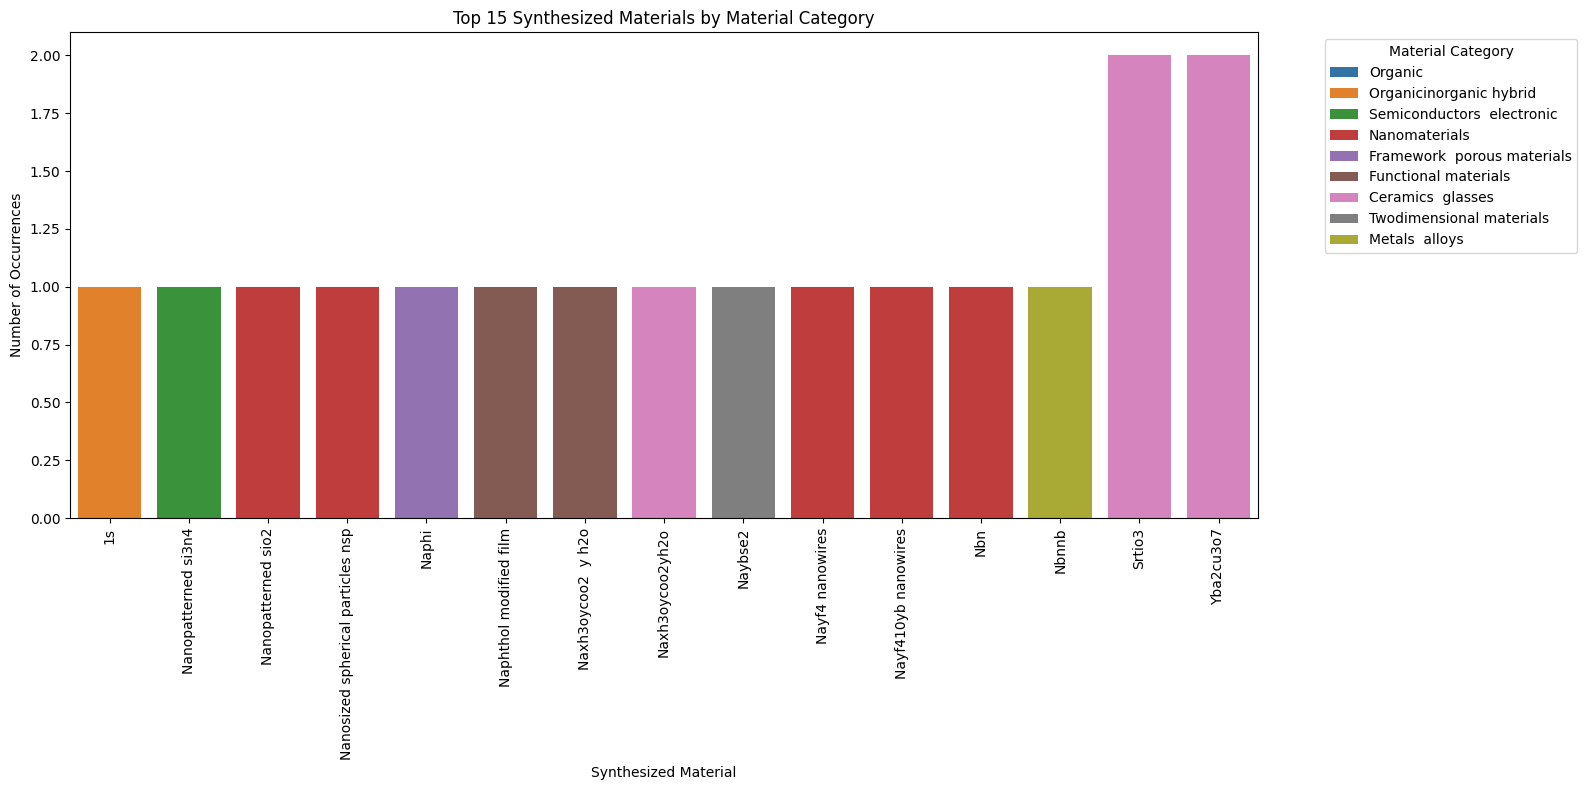

In [ ]:
# Easy cleaning
def clean(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text).strip().capitalize()
        if text.lower() not in ['material', 'science', 'others', 'other', 'n/a', 'na']:
            return text
    return None

# Clean both columns
data["clean_material"] = data["material_category"].apply(clean)
data["clean_synth"] = data["synthesized_material"].apply(clean)

# Delete rows where either of the two is empty
df = data.dropna(subset=["clean_material", "clean_synth"])

# Group and count pairs
grouped = df.groupby(["clean_synth", "clean_material"]).size().reset_index(name="count")

# Choose the best synthesised materials to avoid overload
top_synths = grouped.groupby("clean_synth")["count"].sum().sort_values(ascending=False).head(15).index
filtered = grouped[grouped["clean_synth"].isin(top_synths)]

# Grouped plot
plt.figure(figsize=(16, 8))
sns.barplot(
    data=filtered,
    x="clean_synth",
    y="count",
    hue="clean_material",
    palette="tab10",
    dodge=False
)

plt.title("Top 15 Synthesized Materials by Material Category")
plt.xlabel("Synthesized Material")
plt.ylabel("Number of Occurrences")
plt.xticks(rotation=90, ha='center')

plt.legend(title="Material Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### **Correlation between synthesized materials and synthesis methods**

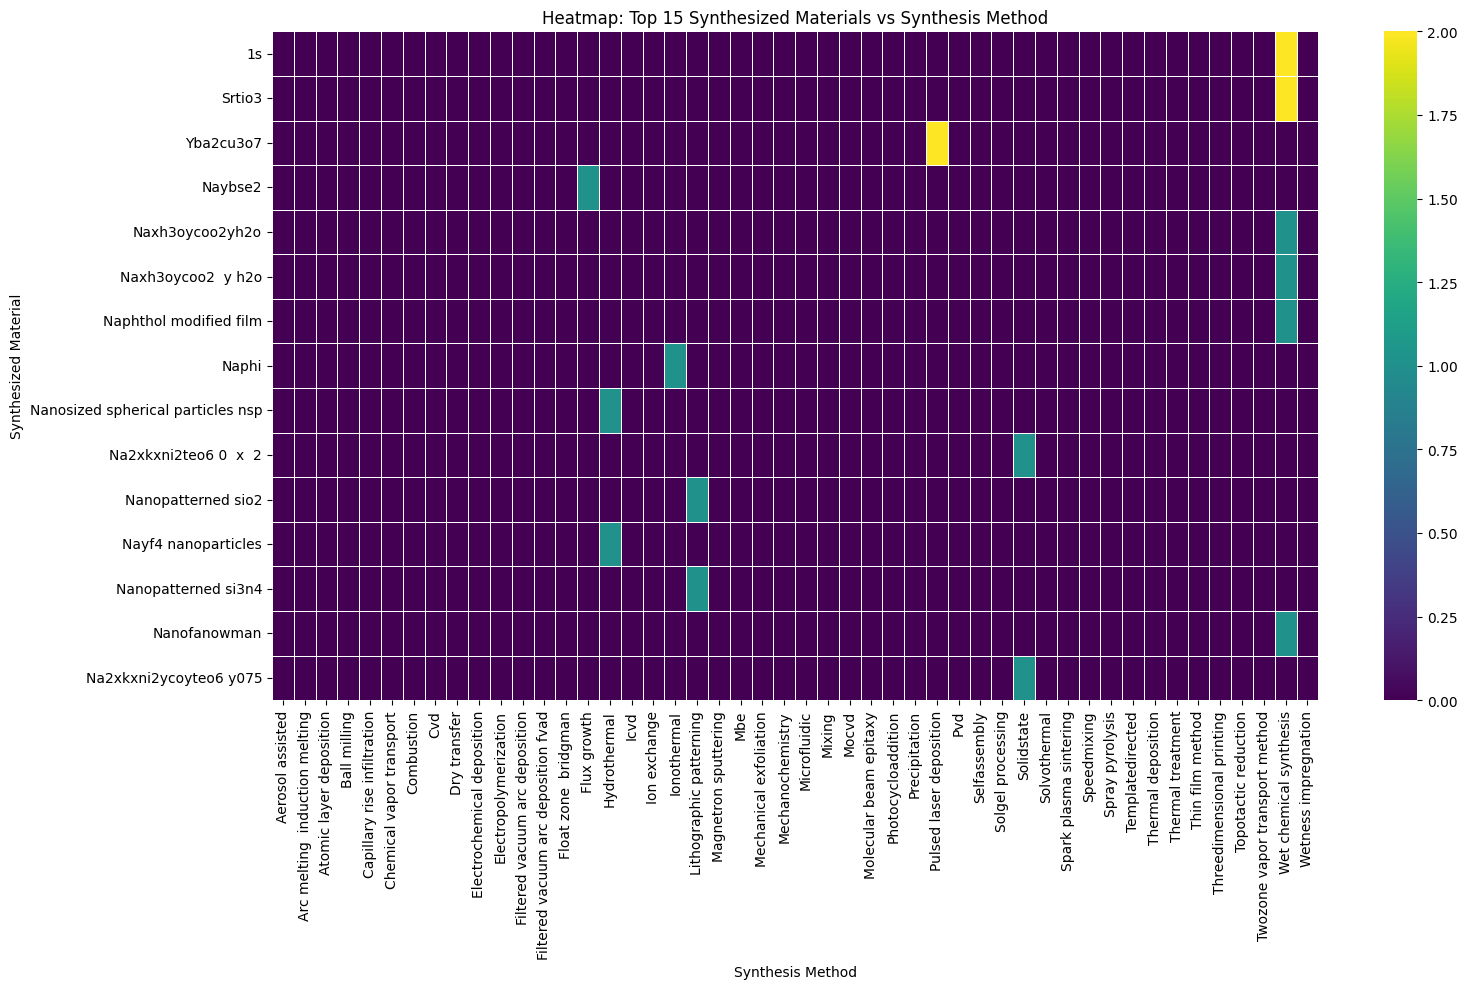

In [ ]:
data["clean_method"] = data["synthesis_method"].apply(clean)

# Create a crosstab (pivot table)
pivot_table = pd.crosstab(data["clean_synth"], data["clean_method"])

# Get the top 15 most synthesized materials
top_synths = pivot_table.sum(axis=1).sort_values(ascending=False).head(15).index

# Filter the pivot table to include only the top 15 materials
filtered_pivot_table = pivot_table.loc[top_synths]

# Display as a heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(filtered_pivot_table, cmap="viridis", linewidths=0.5, annot=False)
plt.title("Heatmap: Top 15 Synthesized Materials vs Synthesis Method")
plt.xlabel("Synthesis Method")
plt.ylabel("Synthesized Material")
plt.tight_layout()
plt.show()

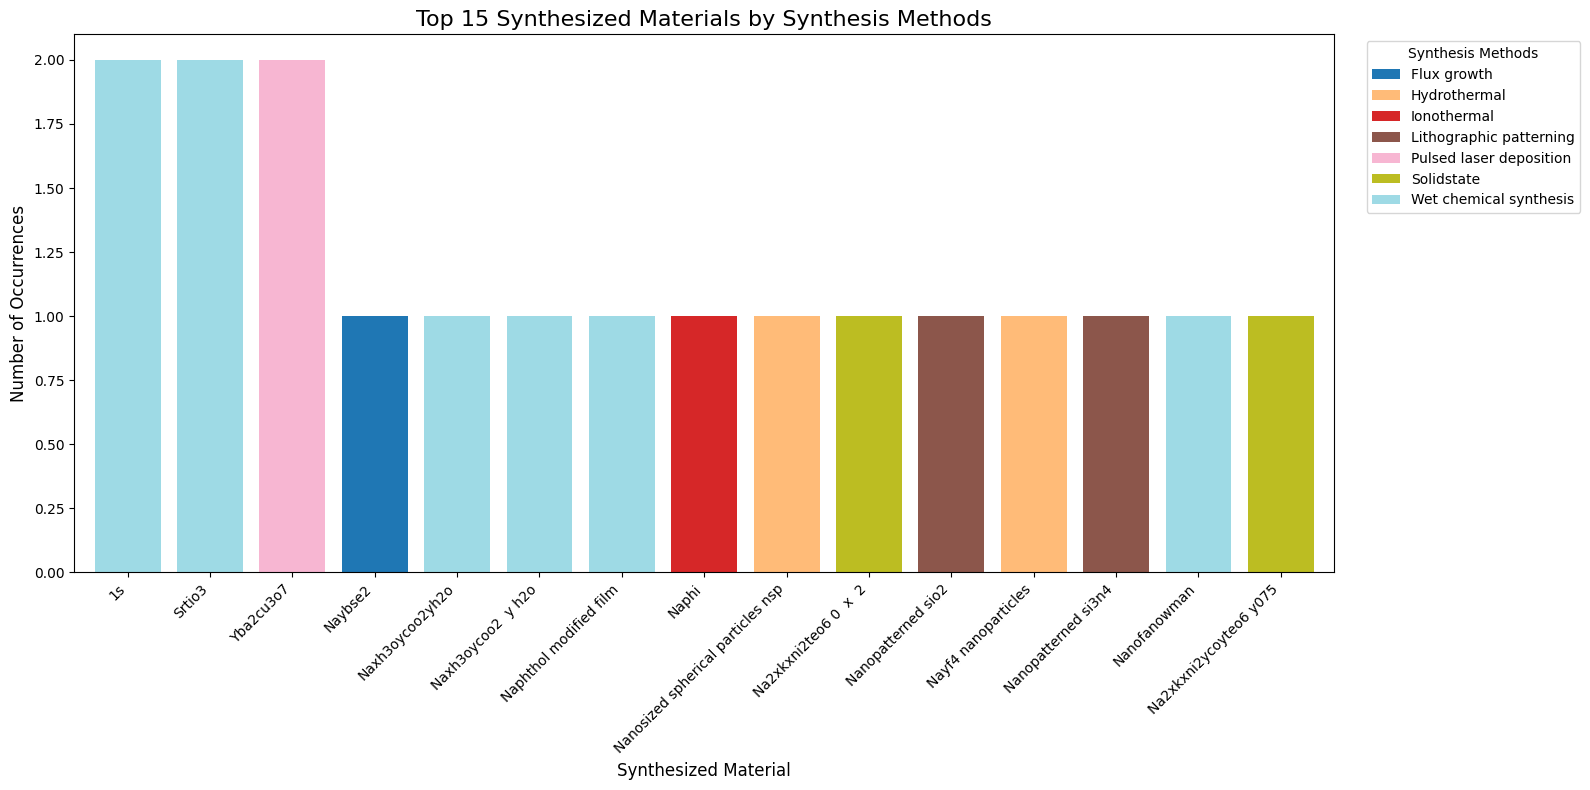

In [ ]:
# Delete rows where either of the two is empty
df = data.dropna(subset=["clean_method", "clean_synth"])

# Group and count pairs
grouped = df.groupby(["clean_synth", "clean_method"]).size().reset_index(name="count")

# Choose the best synthesised materials to avoid overload
top_synths = grouped.groupby("clean_synth")["count"].sum().sort_values(ascending=False).head(15).index
filtered = grouped[grouped["clean_synth"].isin(top_synths)]


# --- TRANSFORMATION TO STACKED BAR CHART ---

# 1. Pivot the data to a "wide" format suitable for stacking
pivot_df = filtered.pivot_table(
    index='clean_synth',
    columns='clean_method',
    values='count',
    fill_value=0 # Fills in 0 for any material/method pair that doesn't exist
)

# 2. Reorder the data to match the top 15 sorted list
pivot_df = pivot_df.reindex(top_synths)

# 3. Create the stacked bar plot from the new pivoted DataFrame
ax = pivot_df.plot(
    kind='bar',
    stacked=True,
    figsize=(16, 8),
    width=0.8,
    colormap="tab20"
)

plt.title("Top 15 Synthesized Materials by Synthesis Methods", fontsize=16)
plt.xlabel("Synthesized Material", fontsize=12)
plt.ylabel("Number of Occurrences", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Synthesis Methods", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

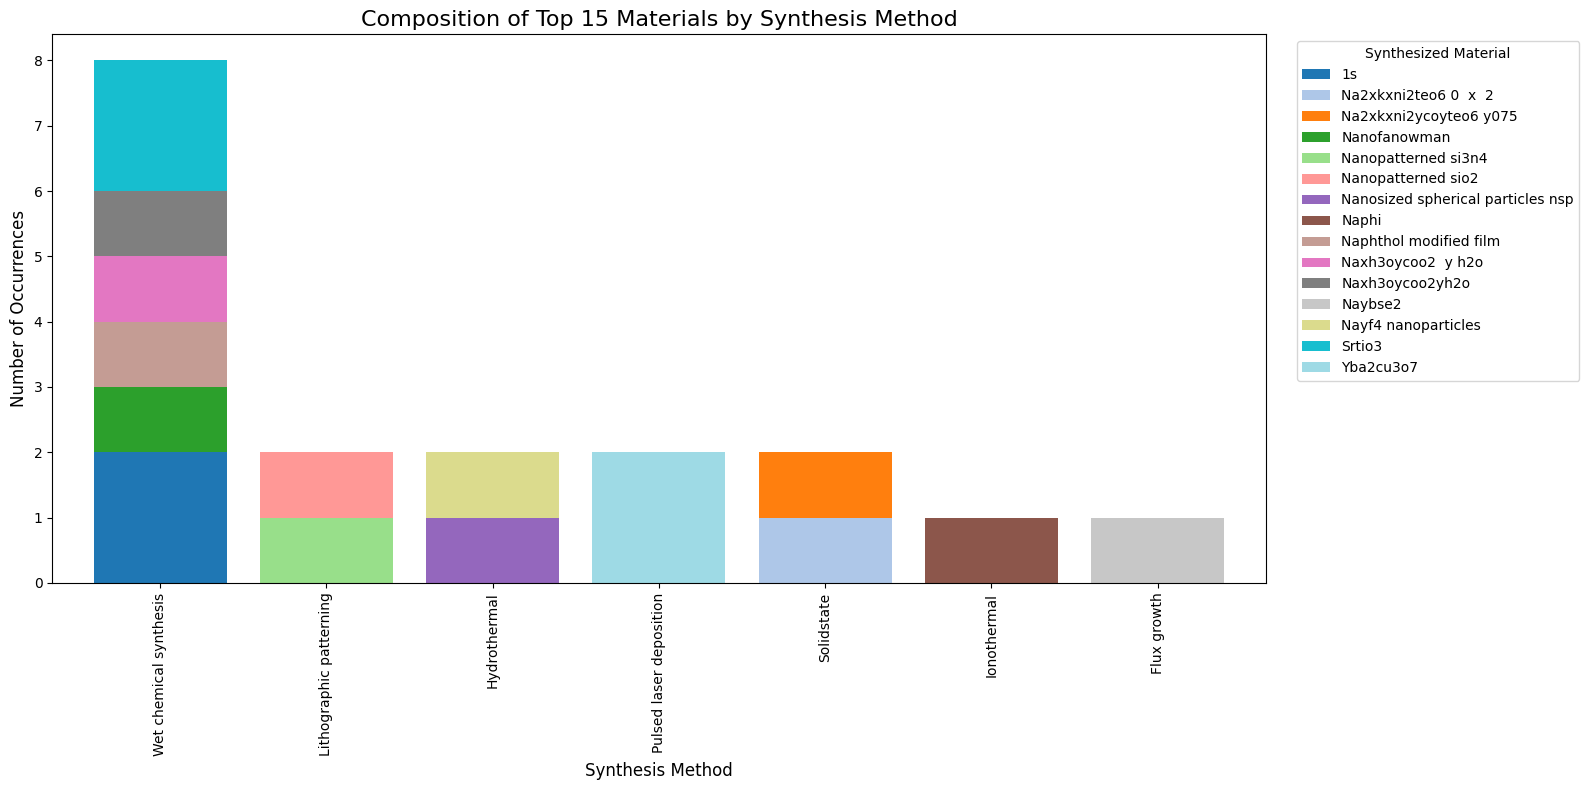

In [ ]:
# --- TRANSFORMATION TO INVERTED STACKED CHART ---

# 1. Invert the pivot table 🔄
# The methods are now the rows (x-axis) and materials are the columns (legend).
pivot_df_swapped = filtered.pivot_table(
    index='clean_method',
    columns='clean_synth',
    values='count',
    fill_value=0
)

# 2. Optional but recommended: Sort the methods by total occurrences
method_order = pivot_df_swapped.sum(axis=1).sort_values(ascending=False).index
pivot_df_swapped = pivot_df_swapped.reindex(method_order)


# 3. Create the stacked bar plot from the new pivoted DataFrame
ax = pivot_df_swapped.plot(
    kind='bar',
    stacked=True,
    figsize=(16, 8),
    width=0.8,
    colormap="tab20"
)

plt.title("Composition of Top 15 Materials by Synthesis Method", fontsize=16)
plt.xlabel("Synthesis Method", fontsize=12)
plt.ylabel("Number of Occurrences", fontsize=12)
plt.xticks(rotation=90, ha="center")
plt.legend(
    title="Synthesized Material",
    bbox_to_anchor=(1.02, 1),
    loc='upper left'
)
plt.tight_layout()
plt.show()

### **Synthesis Methods by source**

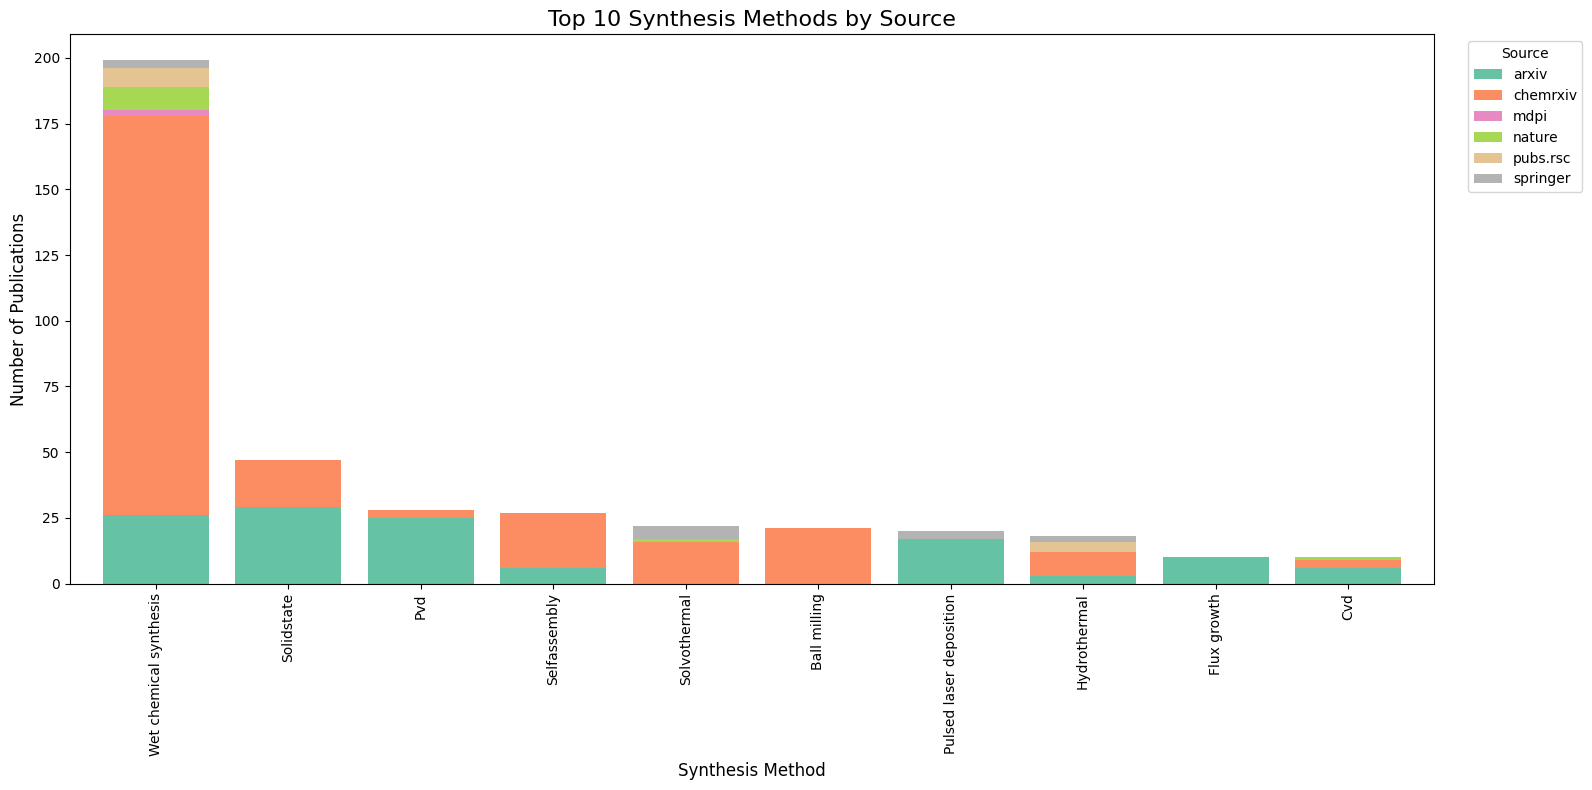

In [ ]:
# Clean synthesis methods
def clean_method(method):
    if isinstance(method, str):
        method = re.sub(r'[^a-zA-Z0-9\s]', '', method).strip().capitalize()
        if method.lower() not in ['na', 'n/a', 'other', 'others']:
            return method
    return None

# Clean source names
data["clean_method"] = data["synthesis_method"].apply(clean_method)
data["clean_source"] = data["source"].astype(str).str.replace(
    r'^www\.|^onlinelibrary\.|\.(org|com|net|edu|info)$', '', regex=True
)

# Drop rows with missing values
df = data.dropna(subset=["clean_method", "clean_source"])

# Group and count occurrences
grouped = df.groupby(["clean_method", "clean_source"]).size().reset_index(name="count")

# --- FILTERING AND PIVOTING ---

# 1. Identify top 10 most common methods
top_methods_order = grouped.groupby("clean_method")["count"].sum() \
                           .sort_values(ascending=False).head(10).index

# 2. Filter to top methods only
filtered = grouped[grouped["clean_method"].isin(top_methods_order)]

# 3. Pivot to wide format (methods as rows, sources as columns)
pivot_df = filtered.pivot_table(
    index="clean_method",
    columns="clean_source",
    values="count",
    fill_value=0
)

# 4. Reorder methods in the DataFrame
pivot_df = pivot_df.reindex(top_methods_order)

# --- PLOTTING STACKED BAR CHART ---

# Create the stacked bar plot
ax = pivot_df.plot(
    kind='bar',
    stacked=True,
    figsize=(16, 8),
    width=0.8,
    colormap="Set2"
)

# Add labels and styling
plt.title("Top 10 Synthesis Methods by Source", fontsize=16)
plt.xlabel("Synthesis Method", fontsize=12)
plt.ylabel("Number of Publications", fontsize=12)
plt.xticks(rotation=90, ha="center")
plt.legend(title="Source", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

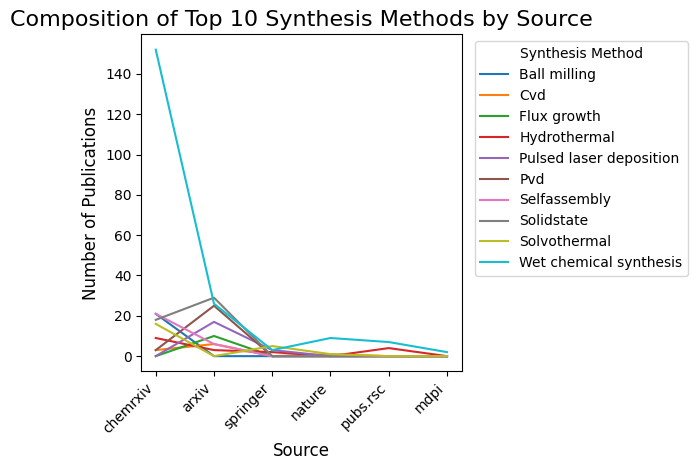

In [ ]:
data["clean_method"] = data["synthesis_method"].apply(clean_method)
data["clean_source"] = data["source"].astype(str).str.replace(r'^www\.|^onlinelibrary\.|\.(org|com|net|edu|info)$', '', regex=True)

df = data.dropna(subset=["clean_method", "clean_source"])
grouped = df.groupby(["clean_method", "clean_source"]).size().reset_index(name="count")

# 1. We still identify the top 10 overall methods to keep the chart focused
top_methods_order = grouped.groupby("clean_method")["count"].sum().sort_values(ascending=False).head(10).index

# 2. Filter data to include only publications using one of these top 10 methods
filtered = grouped[grouped["clean_method"].isin(top_methods_order)]

# 3. Invert the pivot table 🔄
# Now, the sources are the rows (index) and the methods are the columns.
pivot_df_swapped = filtered.pivot_table(
    index='clean_source',
    columns='clean_method',
    values='count',
    fill_value=0
)

# 4. Optional but recommended: Sort the sources by total number of publications
source_order = pivot_df_swapped.sum(axis=1).sort_values(ascending=False).index
pivot_df_swapped = pivot_df_swapped.reindex(source_order)


# 5. Plot the inverted data as a stacked bar chart
ax = pivot_df_swapped.plot()
kind='bar',
stacked=True,
figsize=(16, 8),
width=0.8,
colormap="tab20"

# Styling the plot with updated labels
plt.title("Composition of Top 10 Synthesis Methods by Source", fontsize=16)
plt.xlabel("Source", fontsize=12)
plt.ylabel("Number of Publications", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(
    title="Synthesis Method",
    bbox_to_anchor=(1.02, 1),
    loc='upper left'
)
plt.tight_layout()
plt.show()

### **Synthesized Materials by source**

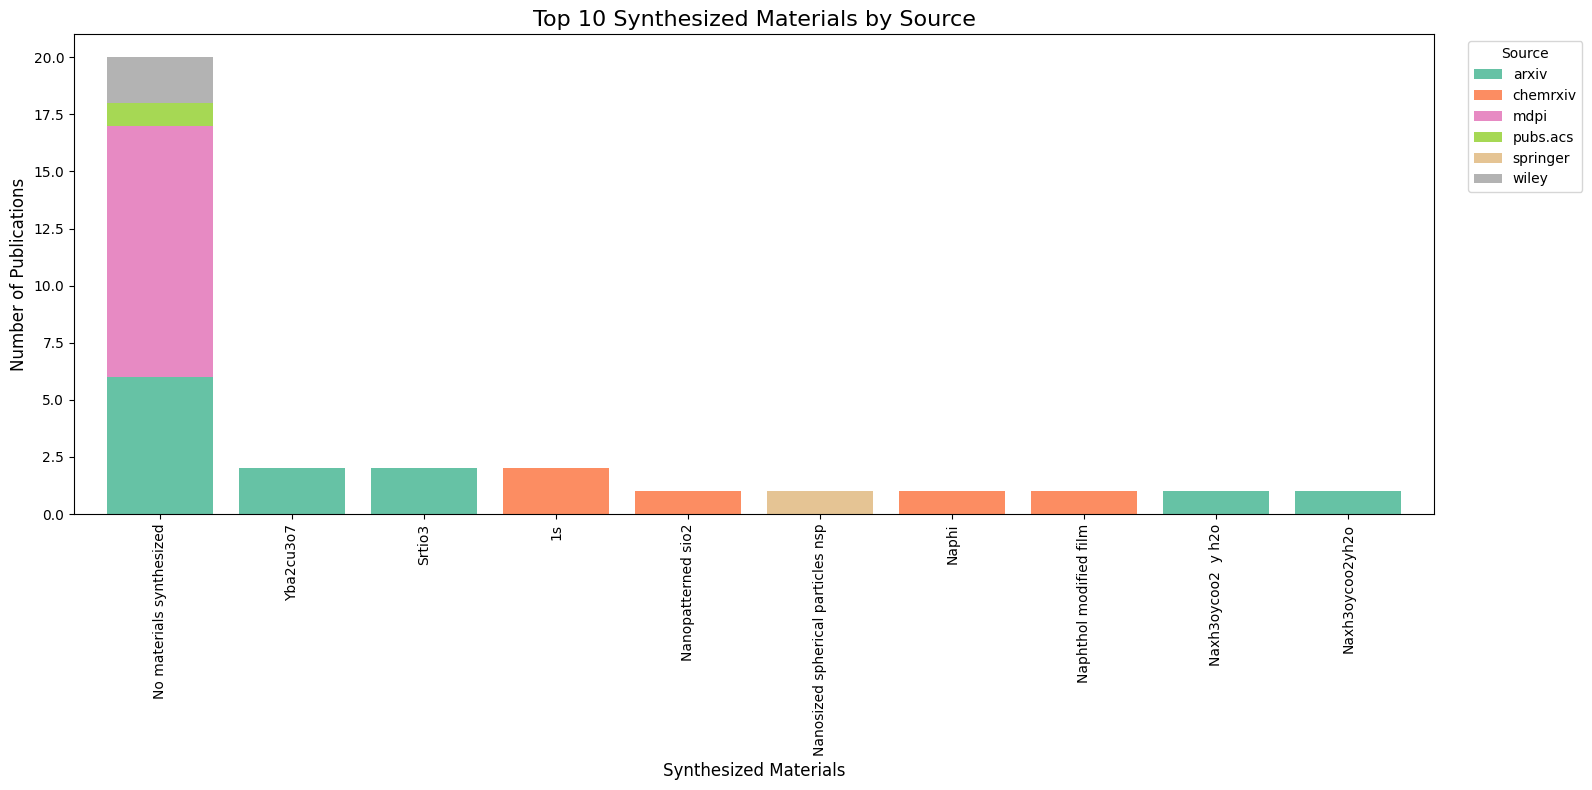

In [ ]:
# Clean synthesis methods
def clean_synth(synth):
    if isinstance(synth, str):
        synth = re.sub(r'[^a-zA-Z0-9\s]', '', synth).strip().capitalize()
        if synth.lower() not in ['na', 'n/a', 'other', 'others']:
            return synth
    return None

# Clean source names
data["clean_synth"] = data["synthesized_material"].apply(clean_synth)
data["clean_source"] = data["source"].astype(str).str.replace(
    r'^www\.|^onlinelibrary\.|\.(org|com|net|edu|info)$', '', regex=True
)

# Drop rows with missing values
df = data.dropna(subset=["clean_synth", "clean_source"])

# Group and count occurrences
grouped = df.groupby(["clean_synth", "clean_source"]).size().reset_index(name="count")

# --- FILTERING AND PIVOTING ---

# 1. Identify top 10 most common synthesized materials
top_synth_order = grouped.groupby("clean_synth")["count"].sum() \
                           .sort_values(ascending=False).head(10).index

# 2. Filter to top synthesized materials only
filtered = grouped[grouped["clean_synth"].isin(top_synth_order)]

# 3. Pivot to wide format (synthesized materials as rows, sources as columns)
pivot_df = filtered.pivot_table(
    index="clean_synth",
    columns="clean_source",
    values="count",
    fill_value=0
)

# 4. Reorder synthesized materials in the DataFrame
pivot_df = pivot_df.reindex(top_synth_order)

# Create the stacked bar plot
ax = pivot_df.plot(
    kind='bar',
    stacked=True,
    figsize=(16, 8),
    width=0.8,
    colormap="Set2"
)

# Add labels and styling
plt.title("Top 10 Synthesized Materials by Source", fontsize=16)
plt.xlabel("Synthesized Materials", fontsize=12)
plt.ylabel("Number of Publications", fontsize=12)
plt.xticks(rotation=90, ha="center")
plt.legend(title="Source", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

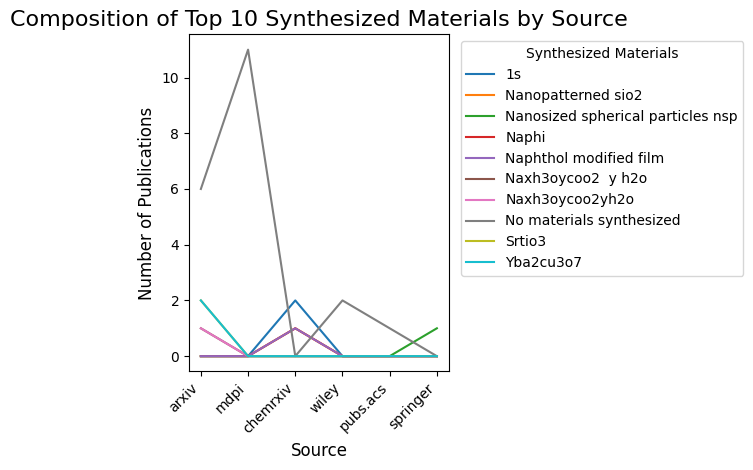

In [ ]:
data["clean_synth"] = data["synthesized_material"].apply(clean_synth)
data["clean_source"] = data["source"].astype(str).str.replace(r'^www\.|^onlinelibrary\.|\.(org|com|net|edu|info)$', '', regex=True)

df = data.dropna(subset=["clean_synth", "clean_source"])
grouped = df.groupby(["clean_synth", "clean_source"]).size().reset_index(name="count")

# 1. We still identify the top 10 overall methods to keep the chart focused
top_synth_order = grouped.groupby("clean_synth")["count"].sum().sort_values(ascending=False).head(10).index

# 2. Filter data to include only publications using one of these top 10 methods
filtered = grouped[grouped["clean_synth"].isin(top_synth_order)]

# 3. Invert the pivot table 🔄
# Now, the sources are the rows (index) and the synthesized materials are the columns.
pivot_df_swapped = filtered.pivot_table(
    index='clean_source',
    columns='clean_synth',
    values='count',
    fill_value=0
)

# 4. Optional but recommended: Sort the sources by total number of publications
source_order = pivot_df_swapped.sum(axis=1).sort_values(ascending=False).index
pivot_df_swapped = pivot_df_swapped.reindex(source_order)


# 5. Plot the inverted data as a stacked bar chart
ax = pivot_df_swapped.plot()
kind='bar',
stacked=True,
figsize=(16, 8),
width=0.8,
colormap="tab20"

# Styling the plot with labels
plt.title("Composition of Top 10 Synthesized Materials by Source", fontsize=16)
plt.xlabel("Source", fontsize=12)
plt.ylabel("Number of Publications", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(
    title="Synthesized Materials",
    bbox_to_anchor=(1.02, 1),
    loc='upper left'
)
plt.tight_layout()
plt.show()